In [128]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from my_xgboost import XGBoost  # 请确保你的自定义XGBoost支持分类
from sklearn.datasets import make_classification
from scipy.sparse import csr_matrix
# 加载数据集
# X_dense, y = make_classification(n_samples=1000, n_features=150, n_informative=10, random_state=42,flip_y=0.2,n_clusters_per_class=2)
# X = csr_matrix(X_dense * (abs(X_dense) > 0.4))  # 只保留较大的值
from sklearn.datasets import load_breast_cancer

# 加载数据
data = load_breast_cancer()
X = data.data  # 特征矩阵 (569个样本 × 30个特征)
y = data.target  # 目标变量 (0: 恶性, 1: 良性)

# 划分数据集（添加分层抽样）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # 保持类别分布
)
# X_train=X_train.toarray()
# X_test=X_test.toarray()

# 结果收集字典
results = {}

def evaluate_model(y_true, y_pred):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1_Macro': f1_score(y_true, y_pred, average='macro'),
        'Precision_Macro': precision_score(y_true, y_pred, average='macro'),
        'Recall_Macro': recall_score(y_true, y_pred, average='macro')
    }


start_time = time.time()
my_model = XGBoost(
    n_estimators=25,
    learning_rate=0.1,
    max_depth=3,
    objective='binaryclass',           # 添加类别数参数
    eps=None,
    global_split=False
)
my_model.fit(X_train, y_train)
train_time = time.time() - start_time


Training XGBoost: 100%|████████████████| 25/25 [elapsed: 00:03 remaining: 00:00]


In [129]:
y_pred = my_model.predict(X_test)
y_pred_proba = 1 / (1 + np.exp(-y_pred))
# 将概率转换为类别预测（默认阈值为0.5）
y_pred_class = (y_pred_proba > 0.5).astype(int)
# 计算Accuracy
accuracy = np.mean(y_pred_class == y_test)
print(f"Accuracy: {accuracy:.4f}")

'''绘制二分类的AUC曲线'''
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.4f}")


Accuracy: 0.9561
AUC: 0.9921


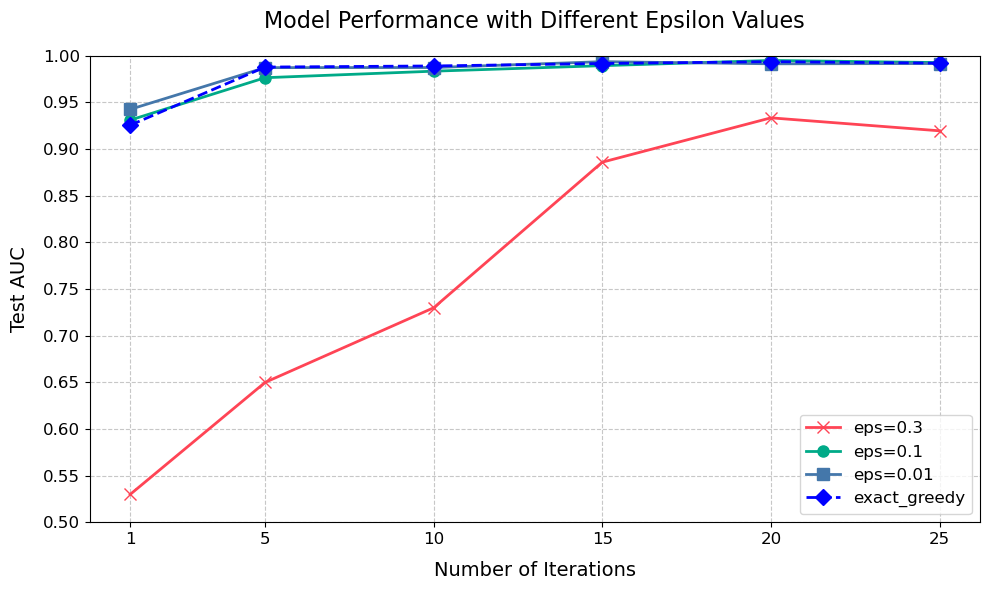

In [134]:
import matplotlib.pyplot as plt
import numpy as np

# 数据配置
iterations = [1, 5, 10, 15, 20, 25]
global_03=[0.667,0.7346,0.7742,0.8121,0.8402]
eps_03 = [0.53, 0.65, 0.73, 0.886, 0.9335, 0.9196]
eps_01 = [0.9311, 0.9765, 0.9835, 0.9894, 0.9950, 0.9927]
eps_001 = [0.9426, 0.9873, 0.9874, 0.9937, 0.9914, 0.9917]
exact_greedy=[0.9256,0.9879,0.9891,0.9917, 0.9937,0.9921]

# 创建画布
plt.figure(figsize=(10, 6), dpi=100)

# 绘制曲线（带不同标记）
plt.plot(iterations, eps_03, 
         marker='x', markersize=8, linestyle='-', color='#FF4455', 
         linewidth=2, label='eps=0.3')
plt.plot(iterations, eps_01, 
         marker='o', markersize=8, linestyle='-', color='#00AA88', 
         linewidth=2, label='eps=0.1')
plt.plot(iterations, eps_001, 
         marker='s', markersize=8, linestyle='-', color='#4477AA', 
         linewidth=2, label='eps=0.01')
plt.plot(iterations, exact_greedy, 
         marker='D', markersize=8, linestyle='--', color='b', 
         linewidth=2, label='exact_greedy')

# 坐标轴美化
plt.xticks(iterations, fontsize=12)
plt.yticks(np.arange(0.5, 1.01, 0.05), 
           [f"{x:.2f}" for x in np.arange(0.5, 1.01, 0.05)], 
           fontsize=12)
plt.ylim(0.5, 1.0)

# 标签与标题
plt.xlabel('Number of Iterations', fontsize=14, labelpad=10)
plt.ylabel('Test AUC', fontsize=14, labelpad=10)
plt.title('Model Performance with Different Epsilon Values', 
          fontsize=16, pad=20)

# 辅助元素
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='lower right', fontsize=12)

# 边距优化
plt.tight_layout()

# 显示图表
plt.show()